In [1]:
from functools import partial
import itertools
import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
import jax.numpy as jnp
from jax.scipy.linalg import expm
from jax_tqdm import scan_tqdm

from gauge_field_utils import coef_to_lie_group, wilson_action, mean_wilson_rectangle

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
### USING WILSON ACTION
parametrized_action = jax.jit(lambda coef, beta: wilson_action(coef_to_lie_group(coef), beta), static_argnames=["beta"])
parametrized_action_grad = jax.jit(jax.grad(parametrized_action), static_argnames=["beta"])
parametrized_action_value_and_grad = jax.jit(jax.value_and_grad(parametrized_action), static_argnames=["beta"])

### USING SYMANZIK ACTION
# parametrized_action = jax.jit(lambda coef, beta: tree_level_improved_action(coef_to_lie_group(coef), beta), static_argnames=["beta"])
# parametrized_action_grad = jax.jit(jax.grad(parametrized_action), static_argnames=["beta"])
# parametrized_action_value_and_grad = jax.jit(jax.value_and_grad(parametrized_action), static_argnames=["beta"])

In [3]:
@partial(jax.jit, static_argnames=["mu", "target_accept", "gamma", "t0", "kappa"])
def dual_averaging_update(log_eps_bar, h, step, accept_prob, mu, target_accept=0.75, gamma=0.05, t0=10, kappa=0.75):
    """Dual-averaging adaptation for step size tuning.
    """
    
    step = step + 1
    
    eta = 1 / (step + t0)
    h = (1 - eta) * h + eta * (target_accept - accept_prob)

    log_eps = mu - jnp.sqrt(step) / gamma * h
    log_eps_bar = jnp.power(step, -kappa) * log_eps + (1 - jnp.power(step, -kappa)) * log_eps_bar

    new_epsilon = jnp.exp(log_eps)

    return new_epsilon, log_eps_bar, h

@partial(jax.jit, static_argnames=["beta", "steps"])
def HMC_trajectory(q0, beta, steps, dt, random_key):
    key1, key2 = jax.random.split(random_key, num=2)
    p0 = jax.random.normal(key1, shape=q0.shape, dtype=q0.dtype)

    def fixed_leapfrog(q0, p0, beta, dt, steps):
        
        U_initial, grad = parametrized_action_value_and_grad(q0, beta)
        H_initial = U_initial + jnp.sum(jnp.square(p0) / 2)

        def step(carry, _):
            qn, pn, gradn = carry
            pn = pn - dt * grad
            qn = qn + dt * pn
            gradn = parametrized_action_grad(qn, beta)
            return (qn, pn, gradn), None

        (q_final, p_final, grad_final), _ = jax.lax.scan(
            step,
            init=(q0, p0+dt/2*grad, grad),
            xs=jnp.arange(steps),
            length=steps
        )

        p_final = p_final - dt/2 * grad_final
        U_final = parametrized_action(q_final, beta)
        H_final = U_final + jnp.sum(jnp.square(p_final) / 2)
        return q_final, p_final, H_final-H_initial

    q_next, _, dH = fixed_leapfrog(q0, p0, beta, dt, steps)
    accept_prob = jnp.min(jnp.array([1, jnp.exp(-dH)]))
    accept = jax.random.uniform(key2) < accept_prob
    q_next = jax.lax.cond(
        accept,
        lambda: q_next,
        lambda: q0
    )

    return {
        "q_next": q_next,
        "dH": dH,
        "accept_prob": accept_prob,
        "was_accepted": accept
    }

def warmup_epsilon(coef, beta, random_key, target_accept=0.651, eps0=1e-3, warmup_iters=300, trajectory_steps=30):

    mu = np.log(10*eps0)
    
    @scan_tqdm(warmup_iters, print_rate=1, tqdm_type="notebook")
    def warmup_step(carry, step):
        coef, eps, log_eps_bar, h, rng_key = carry
        rng_key_new, rng_key = jax.random.split(rng_key)
        
        trajectory = HMC_trajectory(coef, beta, trajectory_steps, eps, rng_key)
        coef = trajectory["q_next"]
        accept_prob = trajectory["accept_prob"]

        jax.debug.print("warmup step {step} : eps={eps} ; p={p} ; dh={dH}", step=step, eps=eps, p=accept_prob, dH=trajectory["dH"])

        eps, log_eps_bar, h = dual_averaging_update(log_eps_bar, h, step, accept_prob, mu, target_accept=target_accept)

        carry = (coef, eps, log_eps_bar, h, rng_key_new)
        return carry, None

    (coef, epsilon, _, _, random_key), _ = jax.lax.scan(
        warmup_step,
        init=(coef, eps0, 0, 0, random_key),
        xs=np.arange(warmup_iters),
        length=warmup_iters
    )
    
    return coef, epsilon

def warmup_tint(coef, beta, random_key, observable_fn, eps, warmup_iters=2000, trajectory_steps=30):
    
    @scan_tqdm(warmup_iters, print_rate=1, tqdm_type="notebook")
    def warmup_step(carry, step):
        coef, rng_key = carry
        rng_key_new, rng_key = jax.random.split(rng_key)
        
        coef = HMC_trajectory(coef, beta, trajectory_steps, eps, rng_key)["q_next"]
        o = observable_fn(coef)
        jax.debug.print("warmup step {step} ; o={o}", step=step, o=o)

        carry = (coef, rng_key_new)
        return carry, o

    (coef, random_key), O = jax.lax.scan(
        warmup_step,
        init=(coef, random_key),
        xs=np.arange(warmup_iters),
        length=warmup_iters
    )
    O = O.reshape(-1)

    tint = 1 + 2*sum([jnp.corrcoef(O[:-s], O[s:])[0, 1] for s in range(len(O) // 2)])
    
    return coef, tint, O

@partial(jax.jit, static_argnames=["R_range", "T_range"])
def calculate_wilson_loops(gauge_coef, R_range, T_range):
    R_min, R_max = R_range
    T_min, T_max = T_range
    wilson_loop_values = jnp.array([mean_wilson_rectangle(coef_to_lie_group(gauge_coef), R, T, time_unique=False) for R, T in itertools.product(range(R_min, R_max+1), range(T_min, T_max+1))]).reshape(R_max-R_min+1, T_max-T_min+1)
    return wilson_loop_values

In [4]:
L = (16, 8, 8, 8)
R_range = (1, 8)
T_range = (1, 16)

random_key, key1, key2 = jax.random.split(jax.random.key(0), num=3)
coef = jax.random.normal(key1, shape=(*L, 4, 8), dtype=jnp.float32)

In [5]:
coef, eps = warmup_epsilon(
    coef,
    eps0=1e-3,
    beta=6.7,
    target_accept=0.4,
    random_key=key2,
    trajectory_steps=80,
)

2025-03-07 02:57:36.584870: W external/xla/xla/hlo/transforms/host_offloader.cc:360] Token parameters are not supported for streaming.


warmup step 0 : eps=0.0010000000474974513 ; p=0.0 ; dh=363.75


Running for 300 iterations:   0%|          | 0/300 [00:00<?, ?it/s]

warmup step 1 : eps=0.0048322491347789764 ; p=0.0 ; dh=18091.59375
warmup step 2 : eps=0.001517352182418108 ; p=0.0 ; dh=894.125
warmup step 3 : eps=0.00040858829743228853 ; p=1.7046798519331288e-25 ; dh=57.03125
warmup step 4 : eps=0.00010343165195081383 ; p=0.028367817401885986 ; dh=3.5625
warmup step 5 : eps=2.799618596327491e-05 ; p=0.7788007855415344 ; dh=0.25
warmup step 6 : eps=7.6196069130674e-05 ; p=0.1353352814912796 ; dh=2.0
warmup step 7 : eps=3.083365663769655e-05 ; p=0.7316156029701233 ; dh=0.3125
warmup step 8 : eps=8.267851080745459e-05 ; p=0.10215643048286438 ; dh=2.28125
warmup step 9 : eps=3.153855504933745e-05 ; p=0.7316156029701233 ; dh=0.3125
warmup step 10 : eps=8.928908937377855e-05 ; p=0.06805085390806198 ; dh=2.6875
warmup step 11 : eps=3.145973096252419e-05 ; p=0.687289297580719 ; dh=0.375
warmup step 12 : eps=7.910498970886692e-05 ; p=0.1194329708814621 ; dh=2.125
warmup step 13 : eps=3.353258580318652e-05 ; p=0.687289297580719 ; dh=0.375
warmup step 14 : ep

E0307 02:58:34.866478    9135 pjrt_stream_executor_client.cc:3050] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_9135/4292446370.py", line 1, in <module>
  File "/tmp/ipykernel_9135/3360313219.py", line 83, in warmup_epsilon
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/lax/control_flow/loops.py", line 331, in scan
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 502, in bind
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 520, in _true_bind
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 525, in bind_with_trace
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/core.py", line 1024, in process_primitive
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/dispatch.py", line 90, in apply_primitive
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/pjit.py", line 341, in cache_miss
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/pjit.py", line 195, in _python_pjit_helper
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/pjit.py", line 1679, in _pjit_call_impl_python
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/profiler.py", line 334, in wrapper
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1287, in __call__
  File "/home/ubuntu/miniconda3/envs/lattice-qcd/lib/python3.11/site-packages/jax/_src/callback.py", line 777, in _wrapped_callback
KeyboardInterrupt: 

In [6]:
coef, tint, O = warmup_tint(
    coef,
    beta=6.7,
    random_key=random_key,
    observable_fn=jax.jit(lambda x: mean_wilson_rectangle(coef_to_lie_group(x), 3, 3, time_unique=False).real),
    eps=5.2e-5,
    warmup_iters=2000,
    trajectory_steps=80
)

2025-03-07 02:58:44.333454: W external/xla/xla/hlo/transforms/host_offloader.cc:360] Token parameters are not supported for streaming.


warmup step 0 ; o=-0.0020790603011846542


Running for 2,000 iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

warmup step 1 ; o=-0.0020790603011846542
warmup step 2 ; o=-0.0020790603011846542
warmup step 3 ; o=-0.0020790603011846542
warmup step 4 ; o=-0.0020790603011846542
warmup step 5 ; o=-0.0020644990727305412
warmup step 6 ; o=-0.0020644990727305412
warmup step 7 ; o=-0.0020442733075469732
warmup step 8 ; o=-0.0020442733075469732
warmup step 9 ; o=-0.0020442733075469732
warmup step 10 ; o=-0.0020442733075469732
warmup step 11 ; o=-0.0021182256750762463
warmup step 12 ; o=-0.0021182256750762463
warmup step 13 ; o=-0.00211994512937963
warmup step 14 ; o=-0.00211994512937963
warmup step 15 ; o=-0.00211994512937963
warmup step 16 ; o=-0.00211994512937963
warmup step 17 ; o=-0.00211994512937963
warmup step 18 ; o=-0.00211994512937963
warmup step 19 ; o=-0.00211994512937963
warmup step 20 ; o=-0.00211994512937963
warmup step 21 ; o=-0.0020138630643486977
warmup step 22 ; o=-0.0020156018435955048
warmup step 23 ; o=-0.0020156018435955048
warmup step 24 ; o=-0.0020156018435955048
warmup step 25 ; 

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 0 for shapes (1, 0), (1, 2000).

In [14]:
wilson_loops = []

for i in tqdm(range(20000)):
    random_key, key1 = jax.random.split(random_key)
    coef = HMC_trajectory(coef, beta=6.7, steps=80, dt=3e-5, random_key=key1)["q_next"]

    # Calculate wilson loops
    wilson_loops.append(calculate_wilson_loops(coef, R_range, T_range))

In [14]:
wilson_loops = jnp.array(wilson_loops)
mean_loops = jnp.real(wilson_loops[200:].mean(axis=0)).copy()
omrt_loops = 1 - mean_loops/3

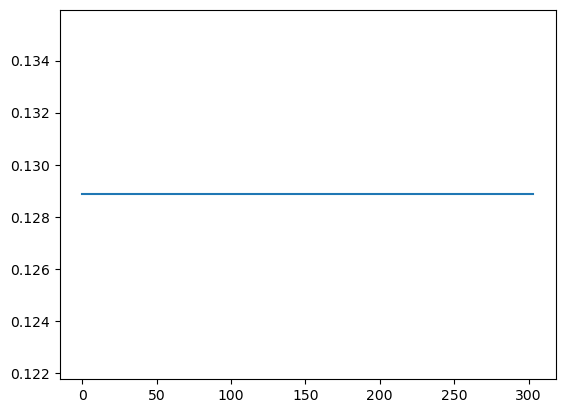

In [15]:
plt.plot(wilson_loops[:, 0, 0].real)
plt.show()

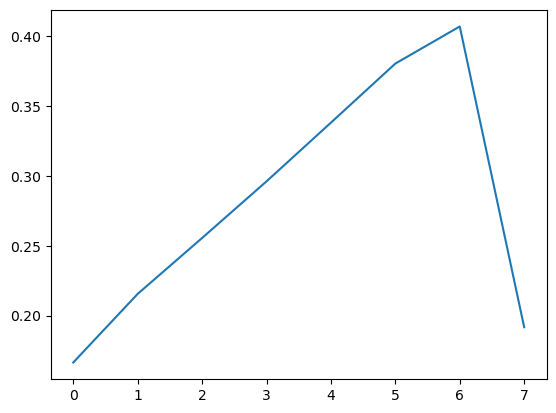

In [51]:
i=7
plt.plot(jnp.log(mean_loops[:,i]/mean_loops[:,i+1]))
plt.show()